#Restaurant Recommendation System

In [ ]:
#Importing the required libraries

import numpy as np
import pandas as pd
import json
import zipfile
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten,Dense,Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from operator import itemgetter
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
%matplotlib inline

2.8.0


In [ ]:
#mount the google drive to access the dataet
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/mydrive


In [ ]:
#Unzipping the yelp_dataset.tar file
!tar -xvf  '/content/drive/MyDrive/yelp_dataset.tar' -C '/content/'

Dataset_User_Agreement.pdf
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json


In [ ]:
#Creating the directories for business,user,review file

business_dir="/content/yelp_academic_dataset_business.json"
user_dir="/content/yelp_academic_dataset_user.json"
review_dir="/content/yelp_academic_dataset_review.json"


In [ ]:
# Function to see the first five rows of dataframe
def rows(filepath, nrows = None):
    with open(filepath) as json_file:
        count = 0
        objs = []
        line = json_file.readline()
        while (nrows is None or count < nrows) and line:
            count += 1
            obj = json.loads(line)
            objs.append(obj)
            line = json_file.readline()
        return pd.DataFrame(objs)

In [ ]:
#let's have a quick look of business dataset
rows(business_dir,5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [ ]:
#let's have a quick look of user dataset
rows(user_dir,5)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,3.85,1710,163,190,361,147,1212,5691,2541,2541,815,323
1,dIIKEfOgo0KqUfGQvGikPg,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...","XPzYf9_mwG2eXYP2BAGSTA, 2LooM5dcIk2o01nftYdPIg...",1025,4.09,1632,87,94,232,96,1187,3293,2205,2205,472,294
2,D6ErcUnFALnCQN4b1W_TlA,Jason,119,2007-02-07 15:47:53,188,128,130,"2010,2011","GfB6sC4NJQvSI2ewbQrDNA, jhZtzZNNZJOU2YSZ6jPlXQ...",16,3.76,22,1,3,0,0,5,20,31,31,3,1
3,JnPIjvC0cmooNDfsa9BmXg,Kat,987,2009-02-09 16:14:29,7234,4722,4035,"2009,2010,2011,2012,2013,2014","HQZPQhKMwRAyS6BCselVWQ, kP2U1s_sjQfHO9grxiyDTA...",420,3.77,1180,129,93,219,90,1120,4510,1566,1566,391,326
4,37Hc8hr3cw0iHLoPzLK6Ow,Christine,495,2008-03-03 04:57:05,1577,727,1124,"2009,2010,2011","-Q88pZUcrfN0BLBDp-bkAQ, etPn4Pv1Gc4cRZjRgB_BOw...",47,3.72,248,19,32,16,15,77,131,310,310,98,44


In [ ]:
##let's have a quick look of business dataset
rows(review_dir,5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


Here,we are using yelp database which has 3 tables

**businesses**(business info)

**reviews**(review info)

**users**(user info)

In [ ]:
zipref=zipfile.ZipFile("/content/drive/MyDrive/results (1).zip")
zipref.extractall()
zipref.close()

In [ ]:
db = sq3.connect("/content/yelp_database.db")

In [ ]:
def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_dataframe(query, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in query]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

#Exploratory Data Analysis

In [ ]:
#let's have a look at the columns of businesses table
make_query("PRAGMA table_info(businesses)")

[(0, 'business_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'address', 'VARCHAR', 0, None, 0),
 (3, 'city', 'VARCHAR', 0, None, 0),
 (4, 'state', 'VARCHAR', 0, None, 0),
 (5, 'postal_code', 'VARCHAR', 0, None, 0),
 (6, 'latitude', 'FLOAT', 0, None, 0),
 (7, 'longitude', 'FLOAT', 0, None, 0),
 (8, 'stars', 'FLOAT', 0, None, 0),
 (9, 'review_count', 'INTEGER', 0, None, 0),
 (10, 'is_open', 'BOOLEAN', 0, None, 0),
 (11, 'categories', 'VARCHAR', 0, None, 0),
 (12, 'RestaurantsTableService', 'BOOLEAN', 0, None, 0),
 (13, 'WiFi', 'BOOLEAN', 0, None, 0),
 (14, 'BikeParking', 'BOOLEAN', 0, None, 0),
 (15, 'BusinessParking', 'BOOLEAN', 0, None, 0),
 (16, 'BusinessAcceptsCreditCards', 'BOOLEAN', 0, None, 0),
 (17, 'RestaurantsReservations', 'BOOLEAN', 0, None, 0),
 (18, 'WheelchairAccessible', 'BOOLEAN', 0, None, 0),
 (19, 'Caters', 'BOOLEAN', 0, None, 0),
 (20, 'OutdoorSeating', 'BOOLEAN', 0, None, 0),
 (21, 'RestaurantsGoodForGroups', 'BOOLEAN', 0, None, 0),
 (22, 'Ha

In [ ]:
#let's have a look at the columns of reviews table
make_query("PRAGMA table_info(reviews)")

[(0, 'review_id', 'VARCHAR', 0, None, 1),
 (1, 'user_id', 'INTEGER', 0, None, 0),
 (2, 'business_id', 'INTEGER', 0, None, 0),
 (3, 'stars', 'FLOAT', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'text', 'VARCHAR', 0, None, 0),
 (8, 'date', 'TIMESTAMP', 0, None, 0)]

In [ ]:
#let's have a look at the columns of users table
make_query("PRAGMA table_info(users)")

[(0, 'user_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'review_count', 'INTEGER', 0, None, 0),
 (3, 'yelping_since', 'TIMESTAMP', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'elite', 'VARCHAR', 0, None, 0),
 (8, 'friends', 'VARCHAR', 0, None, 0),
 (9, 'fans', 'INTEGER', 0, None, 0),
 (10, 'average_stars', 'FLOAT', 0, None, 0),
 (11, 'compliment_hot', 'INTEGER', 0, None, 0),
 (12, 'compliment_more', 'INTEGER', 0, None, 0),
 (13, 'compliment_profile', 'INTEGER', 0, None, 0),
 (14, 'compliment_cute', 'INTEGER', 0, None, 0),
 (15, 'compliment_list', 'INTEGER', 0, None, 0),
 (16, 'compliment_note', 'INTEGER', 0, None, 0),
 (17, 'compliment_plain', 'INTEGER', 0, None, 0),
 (18, 'compliment_cool', 'INTEGER', 0, None, 0),
 (19, 'compliment_funny', 'INTEGER', 0, None, 0),
 (20, 'compliment_writer', 'INTEGER', 0, None, 0),
 (21, 'compliment_photos', 'INTEGER', 0, None, 0)]

In [ ]:
#Creating a query to access the columns name of the table
business_cols=list(zip(*make_query("PRAGMA table_info(businesses)")))[1]

In [ ]:
#Creating business dataframe
business_df=make_dataframe(query=make_query("select * from businesses"),legend=business_cols)

In [ ]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,RestaurantsTableService,WiFi,BikeParking,BusinessParking,BusinessAcceptsCreditCards,RestaurantsReservations,WheelchairAccessible,Caters,OutdoorSeating,RestaurantsGoodForGroups,HappyHour,BusinessAcceptsBitcoin,RestaurantsPriceRange2,Ambience,HasTV,Alcohol,GoodForMeal,DogsAllowed,RestaurantsTakeOut,NoiseLevel,RestaurantsAttire,RestaurantsDelivery,GoodForKids,ByAppointmentOnly,Music,GoodForDancing,BestNights,BYOB,CoatCheck,Smoking,DriveThru,BYOBCorkage,Corkage,RestaurantsCounterService,AcceptsInsurance,DietaryRestrictions,AgesAllowed,Open24Hours,HairSpecializesIn,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"Gastropubs, Food, Beer Gardens, Restaurants, B...",1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0
1,1,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",0,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5:0-18:0,5:0-17:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0,5:0-18:0
2,2,Bob Likes Thai Food,3755 Main St,Vancouver,BC,V5V,49.251342,-123.101333,3.5,169,1,"Restaurants, Thai",0,1,1,1,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0,17:0-21:0
3,3,Boxwood Biscuit,740 S High St,Columbus,OH,43206,39.947007,-82.997471,4.5,11,1,"Breakfast & Brunch, Restaurants",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,None,None,None,None,None,8:0-14:0,8:0-14:0
4,4,Chautauqua General Store,100 Clematis Dr,Boulder,CO,80302,39.998449,-105.281006,3.5,5,1,"Food, Shopping, Convenience Stores, Souvenir S...",0,0,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8:0-20:0,8:0-20:0,8:0-20:0,8:0-20:0,8:0-20:0,8:0-20:0,8:0-20:0


let's plot a bar graph to show the total number of open and closed businesses

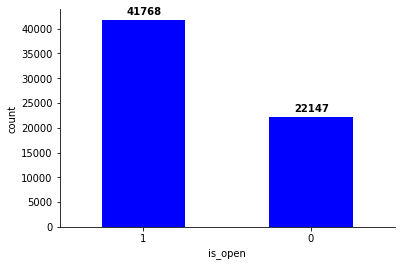

In [ ]:
business_df["is_open"].value_counts(dropna=False).plot(kind="bar",color='blue', rot=0)
for index, value in enumerate(business_df["is_open"].value_counts(dropna=False).values):
    plt.text(index-0.1,value+1000, str(value),fontweight='bold')
plt.xlabel('is_open')
plt.ylabel('count')
sns.despine()

Let's visualize the rating of restaurants for specific attributes


In [ ]:
attrs=["WiFi","BikeParking","BusinessAcceptsCreditCards","OutdoorSeating","RestaurantsGoodForGroups","Alcohol","GoodForMeal","GoodForKids","Smoking","HasTV"]

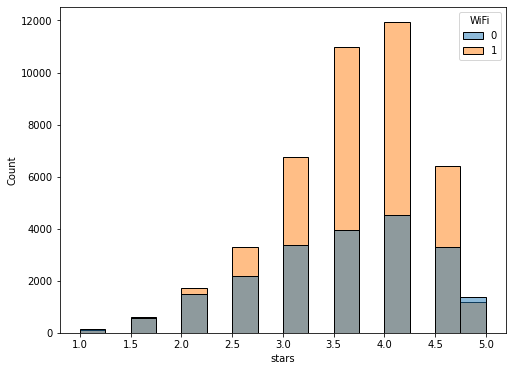

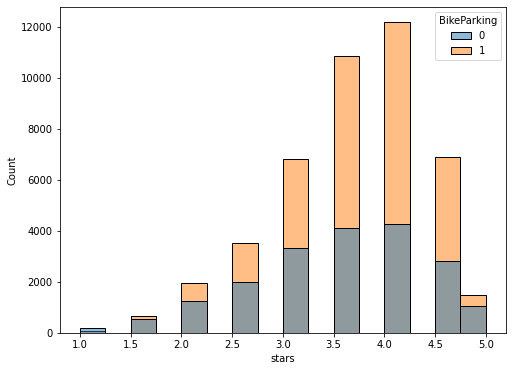

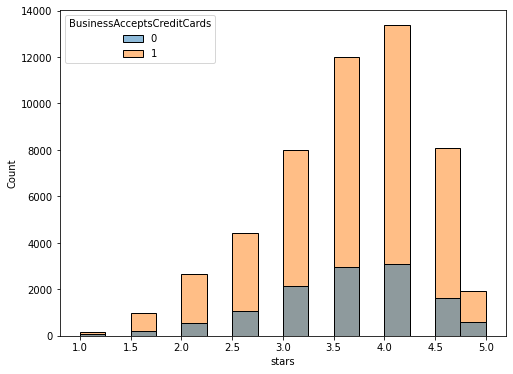

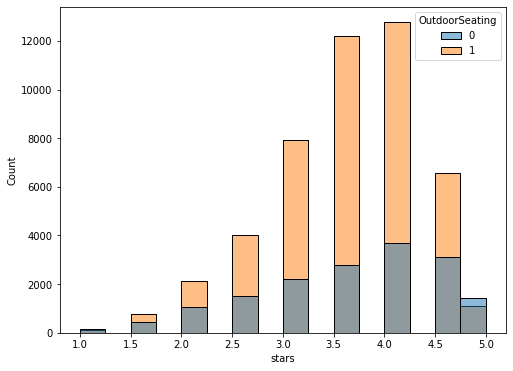

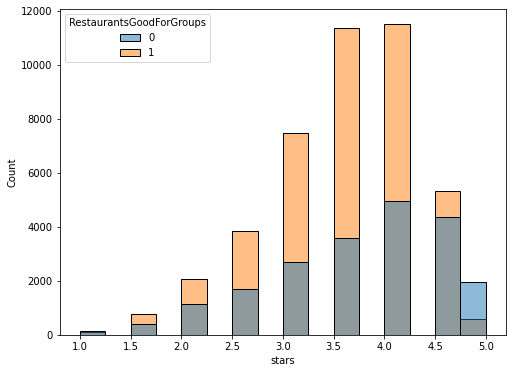

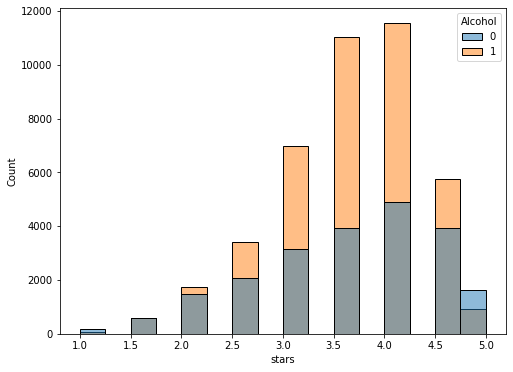

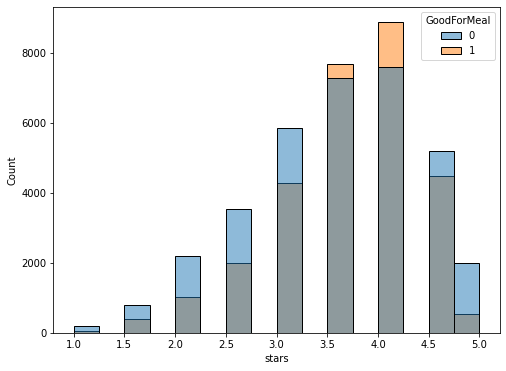

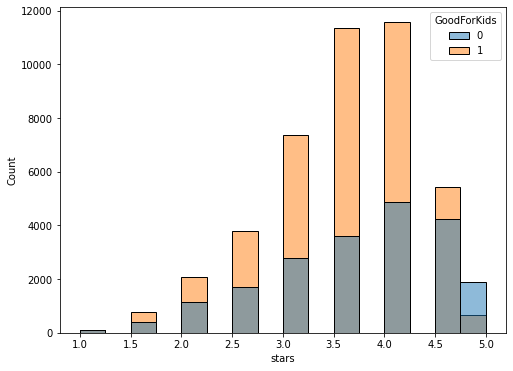

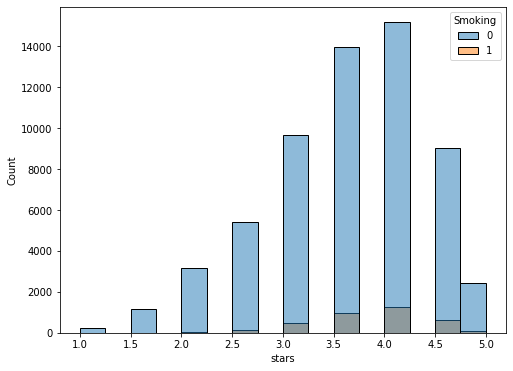

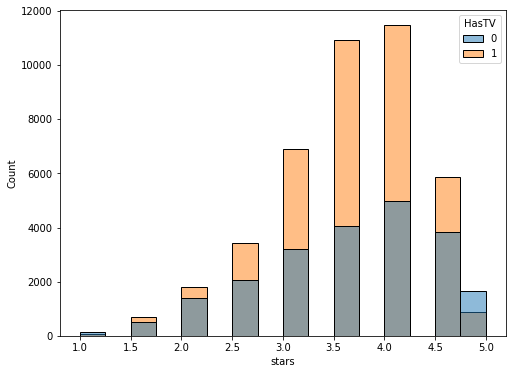

In [ ]:
for i,attr in enumerate(attrs):
  plt.figure(figsize=(8,6))
  sns.histplot(x="stars",data=business_df,hue=attr,binwidth=0.25)
  plt.show()

- Restaurants with WiFi getting higher ratings than those without.<br>
- Peoples also tends to rate higher the restaurants with outdoorseating than those which has indoor seatings <br>
- The restaurants with bikeparking,GoodForGroups,TV,GoodforKids and Open24Hours has better ratings and more count of reviews than those without it.<br>
- Also the restaurants with smoking allowance has lower ratings those which doesn't have smoking allowance.  


Top 10 5star restuarants with highest review_count

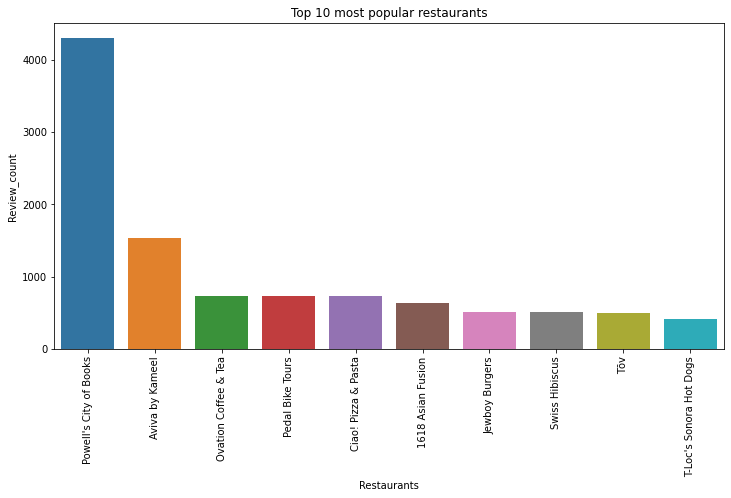

In [ ]:
Top10_df=business_df.sort_values(by=["stars","review_count"],ascending=False).head(10)[["name","stars","review_count"]]
plt.figure(figsize=(12,6))
sns.barplot(x=Top10_df["name"],y=Top10_df["review_count"])
plt.xticks(rotation=90)
plt.xlabel("Restaurants")
plt.ylabel("Review_count")
plt.title("Top 10 most popular restaurants")
plt.show()

Let's Visualize the top indian food restaurants

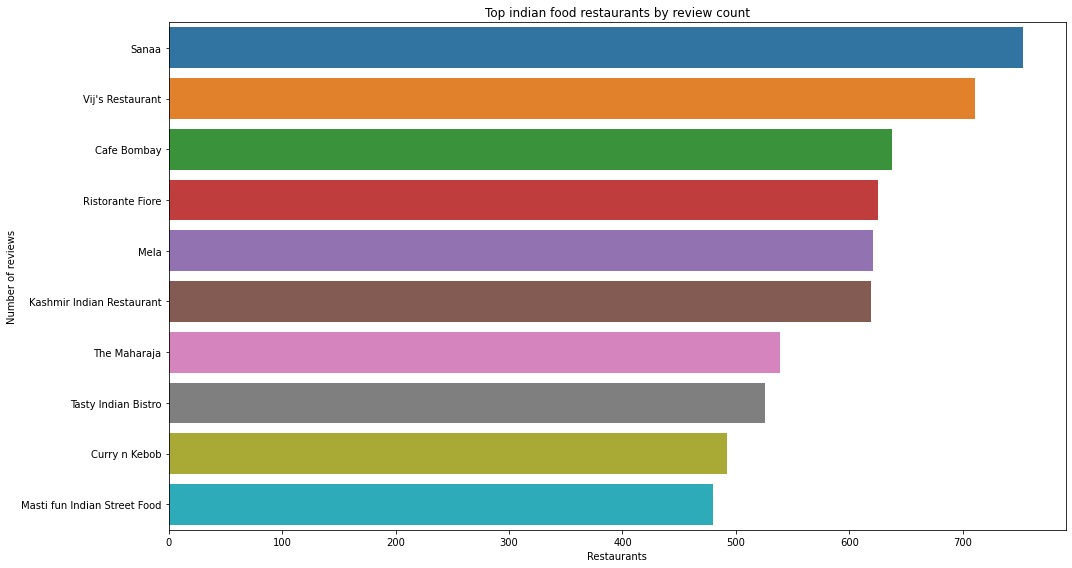

In [ ]:
indian_rest=business_df[business_df["categories"].apply(lambda x:True if "Indian" in x.split() else False)][["name","review_count"]]
indian_rest=indian_rest.groupby(by="name").sum().sort_values(by="review_count",ascending=False).head(10)
plt.figure(figsize=(15,8))
sns.barplot(x=indian_rest.review_count,y=indian_rest.index,orient="h")
plt.title("Top indian food restaurants by review count")
plt.xlabel("Restaurants")
plt.ylabel("Number of reviews")
plt.tight_layout()
plt.show()


Let's visualize how many restaurants we have in specific rating.

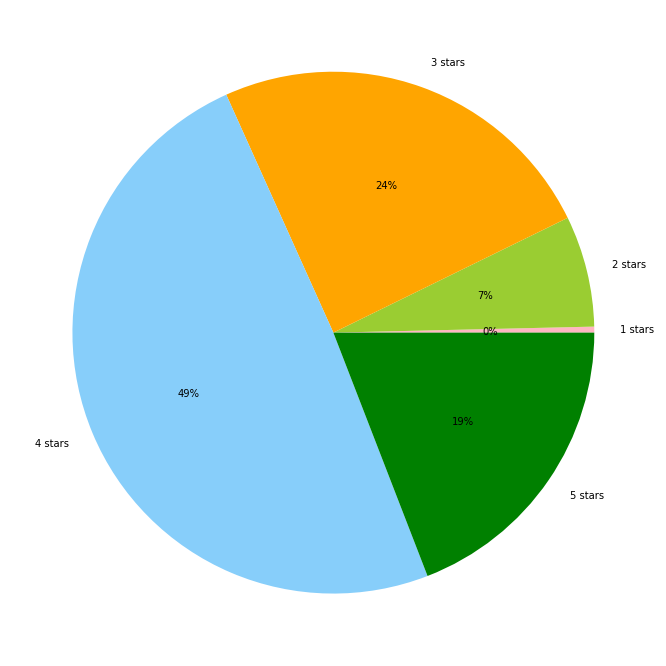

In [ ]:
df=business_df.copy()
df["dummy"]=np.ones(shape=(business_df.shape[0],1))
stars_df=df[["stars","dummy"]].groupby(by="stars").sum()
labels=[str(i)+" stars" for i in range(1,6)]
data=[]
for i in range(5):
  if i==0:
    data.append(stars_df["dummy"].values[0])
  else:
    data.append(sum(stars_df["dummy"].values[2*i-1:2*i+1]))
plt.figure(figsize=(12,12))
colors = ['lightpink', 'yellowgreen', 'orange', 'lightskyblue','green']
plt.pie(x=data,labels=labels,colors=colors,autopct='%.0f%%')
plt.show()

From above plot,we can see that half of the restaurants have been rated as 4 star and almost 0 percent of the restaurants have been rated as 1 stars means most of the peoples gives the rating more than 2 stars to any restaurants.


In [ ]:
users_cols=list(zip(*make_query("PRAGMA table_info(users)")))[1]
user_df=make_dataframe(query=make_query("select * from users"),legend=users_cols)

In [ ]:
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014",[463996],1357,3.85,1710,163,190,361,147,1212,5691,2541,2541,815,323
1,1,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...",[],1025,4.09,1632,87,94,232,96,1187,3293,2205,2205,472,294
2,2,Jason,119,2007-02-07 15:47:53,188,128,130,"2010,2011",[1094856],16,3.76,22,1,3,0,0,5,20,31,31,3,1
3,3,Kat,987,2009-02-09 16:14:29,7234,4722,4035,"2009,2010,2011,2012,2013,2014",[],420,3.77,1180,129,93,219,90,1120,4510,1566,1566,391,326
4,4,Christine,495,2008-03-03 04:57:05,1577,727,1124,"2009,2010,2011",[],47,3.72,248,19,32,16,15,77,131,310,310,98,44


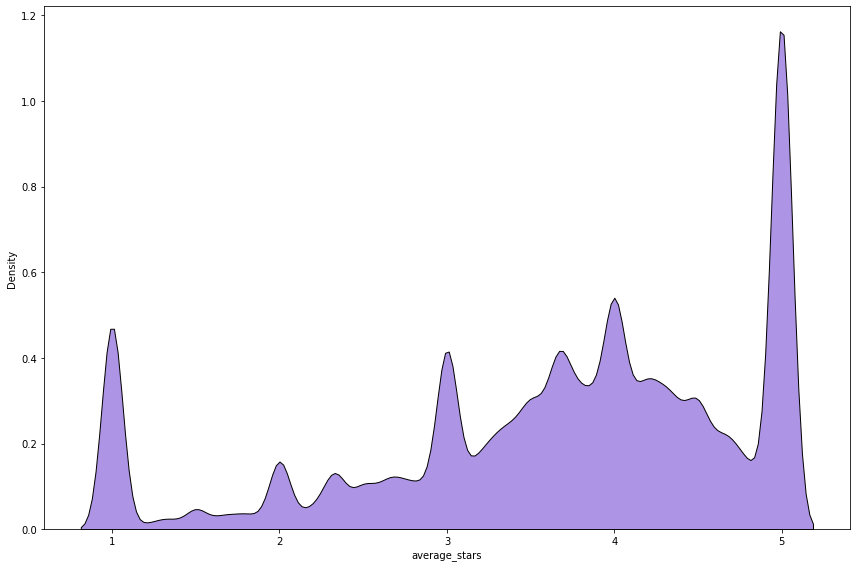

In [ ]:
plt.figure(figsize=(12,8))
sns.kdeplot(x=user_df["average_stars"],color="mediumpurple",multiple="stack")
plt.tight_layout()
plt.show()

From above plot, it seems that we have less users who's average stars is less than 3 and we have so many user's average stars is 5.    

In [ ]:
reviews_cols=list(zip(*make_query("PRAGMA table_info(reviews)")))[1]
review_df=make_dataframe(query=make_query("select text,stars,date from reviews"),legend=["text",'stars','date'])

In [ ]:
review_df.head()

,text,stars,date
0,Apparently Prides Osteria had a rough summer a...,4.0,2014-10-11 03:34:02
1,This store is pretty good. Not as great as Wal...,4.0,2015-07-03 20:38:25
2,I've stayed at many Marriott and Renaissance M...,2.0,2010-01-08 02:29:15
3,The food is always great here. The service fro...,4.0,2011-07-28 18:05:01
4,"This place used to be a cool, chill place. Now...",1.0,2018-01-21 04:41:03


In [ ]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6092999 entries, 0 to 6092998
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   text    object 
 1   stars   float64
 2   date    object 
dtypes: float64(1), object(2)
memory usage: 139.5+ MB


In [ ]:
#Creating one sentence from texts
text="".join(review_df[review_df["stars"]==5]["text"].values[:1000])

###Plotting the wordcloud for the restaurant categories to know what are the most frequently used words in the reviews.

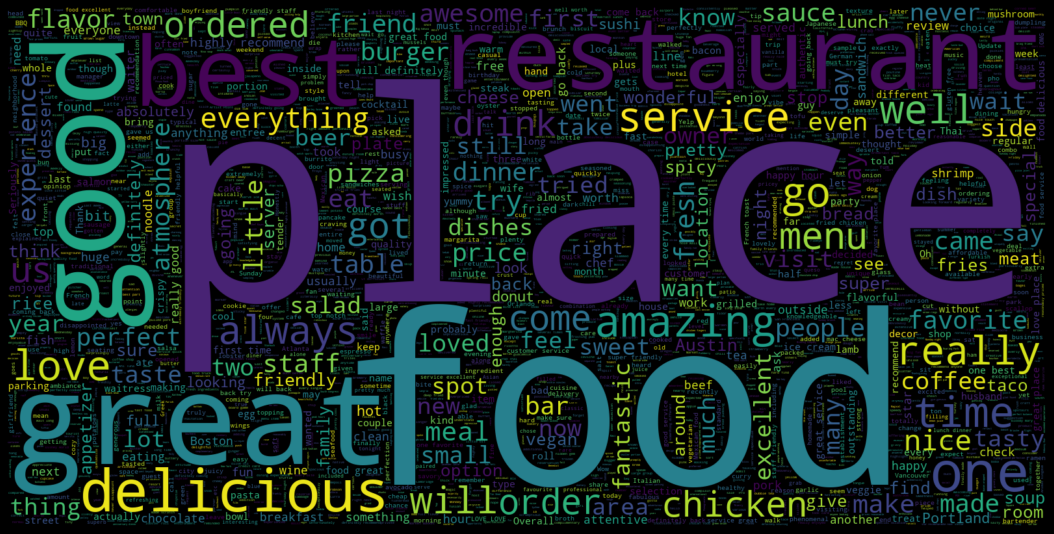

In [ ]:
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(WordCloud(width=1600, height=800, random_state=1, max_words=200000000).generate(text),interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)
plt.show()

In [ ]:
review_df.date = pd.to_datetime(review_df.date)
review_df['day'] = review_df.date.dt.day
review_df['month'] = review_df.date.dt.month
review_df['year'] = review_df.date.dt.year
review_df['hour'] = review_df.date.dt.hour
review_df.head()

,text,stars,date,day,month,year,hour
0,Apparently Prides Osteria had a rough summer a...,4.0,2014-10-11 03:34:02,11,10,2014,3
1,This store is pretty good. Not as great as Wal...,4.0,2015-07-03 20:38:25,3,7,2015,20
2,I've stayed at many Marriott and Renaissance M...,2.0,2010-01-08 02:29:15,8,1,2010,2
3,The food is always great here. The service fro...,4.0,2011-07-28 18:05:01,28,7,2011,18
4,"This place used to be a cool, chill place. Now...",1.0,2018-01-21 04:41:03,21,1,2018,4


Text(0.5, 1.0, 'Number of reviews by Year')

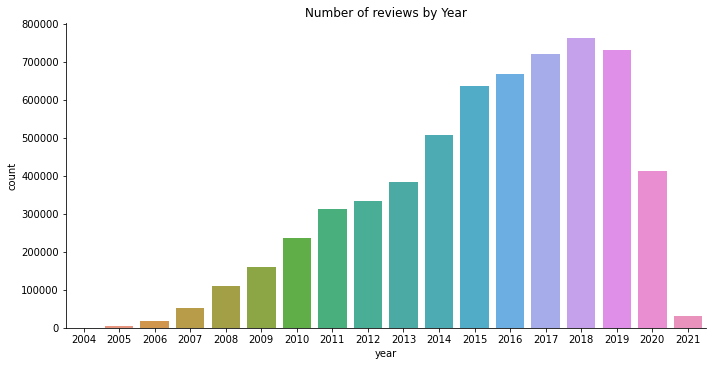

In [ ]:
g = sns.catplot(data=review_df, x='year', kind='count', aspect=2)
ax = plt.gca()
ax.set_title('Number of reviews by Year')

Here we can see that the number of reviews increased exponentially over the years.This could also be an evidence for yelp's popularity over the years.and in 2020 and 2021 the number of reviews has decreased and it could be because of covid pandemic.

Text(0.5, 1.0, 'Review Time')

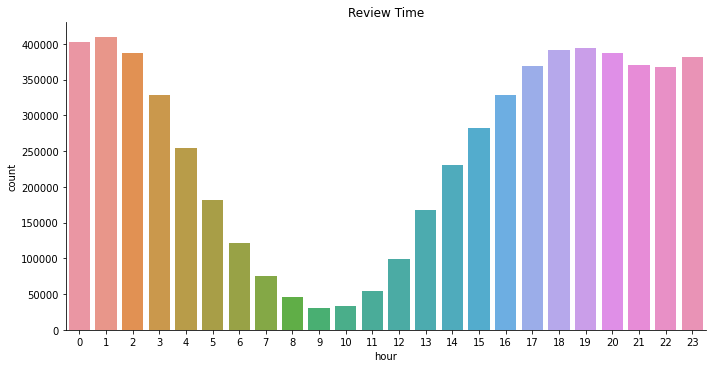

In [ ]:
sns.catplot(data=review_df, x='hour', aspect=2, kind='count')
ax = plt.gca()
ax.set_title('Review Time')

here we see minimum number of reviews were given during morning and count keeps rising throughout the day which seems intuitive. But maximum number of reviews were given at 2am which is counter intuitive. Why are more people reviewing this late? Is it possible that these are bars where people stay for long but why would drunks care about reviewing? Or are people reviewing after dinner during their commute home?

#Modeling

In [ ]:
#getting data for modelling
query=make_query("select user_id, business_id, stars from reviews")
rating_df=make_dataframe(query,legend=["user_id","business_id","stars"])
rating_df.head()

,user_id,business_id,stars
0,92669,1150,4.0
1,102147,6047,4.0
2,147370,1918,2.0
3,2416,1417,4.0
4,59423,342,1.0


In [ ]:
rating_df.shape

(6092999, 3)

In [ ]:
users=rating_df.user_id.nunique()
restaurants=rating_df.business_id.nunique()
print(f"Total number of users: {users}")
print(f"Total number of restaurants: {restaurants}")


Total number of users: 1617955
Total number of restaurants: 63915


In [ ]:
userid2idx = {o:i for i,o in enumerate(rating_df.user_id.unique())}
businid2idx = {o:i for i,o in enumerate(rating_df.business_id.unique())}
rating_df['business_id'] = rating_df.business_id.apply(lambda x: businid2idx[x])
rating_df['user_id'] = rating_df.user_id.apply(lambda x: userid2idx[x])

In [ ]:
rating_df.head()

,user_id,business_id,stars
0,0,0,4.0
1,1,1,4.0
2,2,2,2.0
3,3,3,4.0
4,4,4,1.0


In [ ]:
#creating predictors and response variable
X=rating_df[["user_id","business_id"]]
y=rating_df["stars"]

In [ ]:
# Splitting the data into Train,Val and Test sets

X_train,X_val_test,y_train,y_val_test=train_test_split(X,y,train_size=0.8,random_state=42)

X_val,X_test,y_val,y_test=train_test_split(X_val_test,y_val_test,train_size=0.5,random_state=42)

print(f"X train shape : {X_train.shape}")
print(f"y train shape : {y_train.shape}")

print(f"X val shape : {X_val.shape}")
print(f"y val shape : {y_val.shape}")

print(f"X test shape : {X_test.shape}")
print(f"y test shape : {y_test.shape}")

X train shape : (4874399, 2)
y train shape : (4874399,)
X val shape : (609300, 2)
y val shape : (609300,)
X test shape : (609300, 2)
y test shape : (609300,)


We first set our hypeparameters, the size of the latent factors or the embeddings, up, and the amount of regularization.

In [ ]:
#size of latent factors
L=50
#regularization parameter
REG=1e-3


In [ ]:
# Function to create bias
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

# Function to create embedding vector
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

Also we will create custom sigmoid activation to limit things between 0 and 5.5..we dont want our linear regression to go all over the place...

In [ ]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

##Linear Recommendation System

In [ ]:
user_input, uLmat = embedding_input('user_input',users, L, REG)
rest_input, rLmat = embedding_input('restaurant_input',restaurants, L, REG)
user_bias = create_bias('user_bias', user_input, users, REG)
rest_bias = create_bias('restaurant_bias', rest_input, restaurants, REG)

residual = Dot(axes=2, name="residual")([uLmat, rLmat])
residflat = Flatten(name="residual_flat")(residual)
regression = Add(name="regression")([user_bias, rest_bias, residflat])

cs = sigmoid_maker(0, 5.5)
output = Activation(cs, name="Sigmoid_Range")(regression)
model = Model([user_input, rest_input], output)
model.compile(Adam(0.001), loss='mse')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 restaurant_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 50)        80897750    ['user_input[0][0]']             
                                                                                                  
 restaurant_factor (Embedding)  (None, 1, 50)        3195750     ['restaurant_input[0][0]']       
                                                                                              

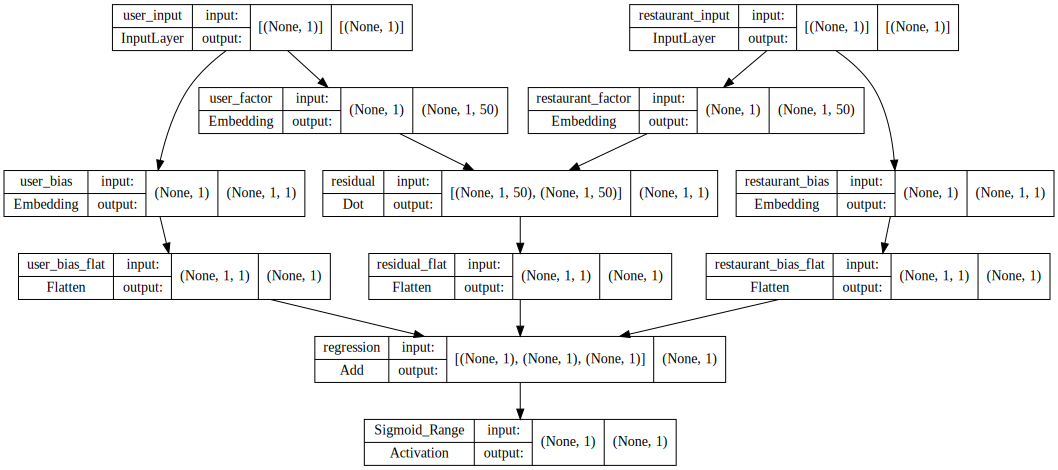

In [ ]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [ ]:
model.optimizer.lr = 0.001
history_1 = model.fit([X_train.user_id, X_train.business_id], y_train, epochs=7,validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=1024, verbose=1)

Epoch 1/7
4761/4761 [==============================] - 4295s 902ms/step - loss: 2.3386 - val_loss: 1.7495
Epoch 2/7
4761/4761 [==============================] - 4329s 909ms/step - loss: 1.5850 - val_loss: 1.5691
Epoch 3/7
4761/4761 [==============================] - 4346s 913ms/step - loss: 1.4315 - val_loss: 1.5116
Epoch 4/7
4761/4761 [==============================] - 4380s 920ms/step - loss: 1.3496 - val_loss: 1.4863
Epoch 5/7
4761/4761 [==============================] - 4441s 933ms/step - loss: 1.2926 - val_loss: 1.4739
Epoch 6/7
1774/4761 [==========>...................] - ETA: 45:07 - loss: 1.2417

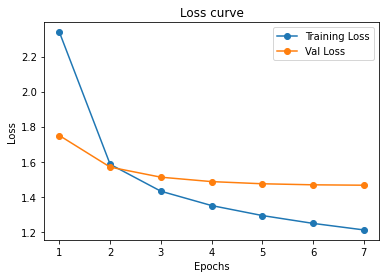

In [ ]:
plt.plot(range(1,8),history_1.history["loss"],label="Training Loss",marker="o")
plt.plot(range(1,8),history_1.history["val_loss"],label="Val Loss",marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.legend()
plt.show()

In [ ]:
test_pred=model.predict([X_test.user_id,X_test.business_id],verbose=1)

19041/19041 [==============================] - 40s 2ms/step


In [ ]:
test_mse=mean_squared_error(y_test,test_pred)
print(f"The MSE of the linear model on test set is {test_mse}")

The MSE of the linear model on test set is 2.4418725749129515


In [ ]:
model.save_weights("model_1.h5")

## Non-Linear Recommendation system

In [ ]:
dense_layer_reg=1e-3

user_input, uLmat = embedding_input('user_input',users, L, REG)
rest_input, rLmat = embedding_input('restaurant_input',restaurants, L, REG)
user_bias = create_bias('user_bias', user_input, users, REG)
rest_bias = create_bias('restaurant_bias', rest_input, restaurants, REG)

residual = Dot(axes=2, name="residual")([uLmat, rLmat])
residflat = Flatten(name="residual_flat")(residual)
regression = Concatenate()([user_bias, rest_bias, residflat])

reg=Dense(64,activation="relu")(regression)
reg=Dense(32,activation="relu")(reg)
output=Dense(1,activation=sigmoid_maker(0.5,5.5),name="Sigmoid_Range")(reg)

model_2 = Model([user_input, rest_input], output)
model_2.compile(Adam(0.001), loss='mse')

In [ ]:
model_2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 restaurant_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 50)        80897750    ['user_input[0][0]']             
                                                                                                  
 restaurant_factor (Embedding)  (None, 1, 50)        3195750     ['restaurant_input[0][0]']       
                                                                                            

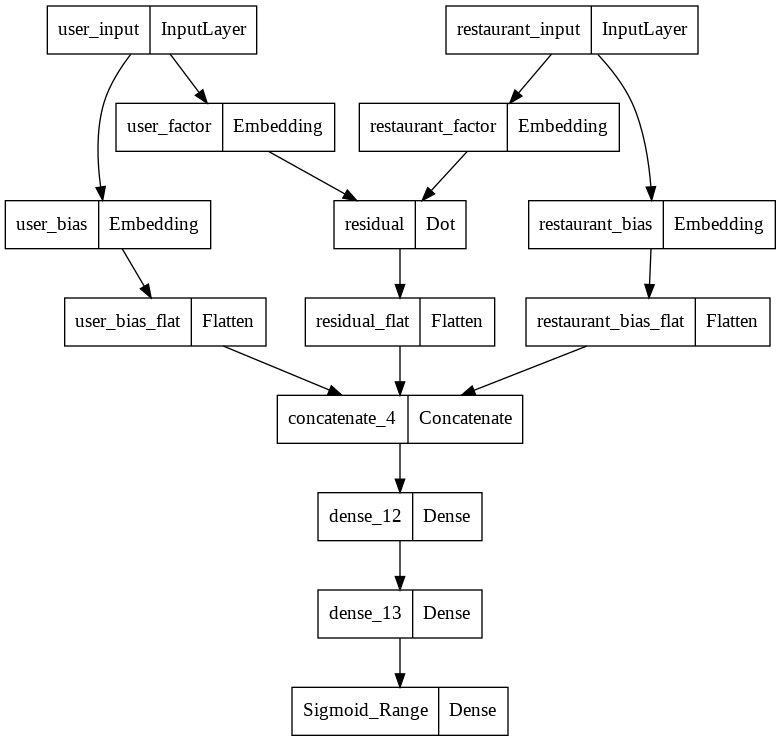

In [ ]:
plot_model(model_2)

In [ ]:
model_2.optimizer.lr = 0.001
history_2 = model_2.fit([X_train.user_id, X_train.business_id], y_train, epochs=5,validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=1024, verbose=1)

Epoch 1/5
4761/4761 [==============================] - 331s 69ms/step - loss: 1.7907 - val_loss: 1.4954
Epoch 2/5
4761/4761 [==============================] - 333s 70ms/step - loss: 1.2819 - val_loss: 1.5196
Epoch 3/5
4761/4761 [==============================] - 332s 70ms/step - loss: 1.1073 - val_loss: 1.5723
Epoch 4/5
4761/4761 [==============================] - 332s 70ms/step - loss: 1.0149 - val_loss: 1.5987
Epoch 5/5
4761/4761 [==============================] - 330s 69ms/step - loss: 0.9599 - val_loss: 1.6198


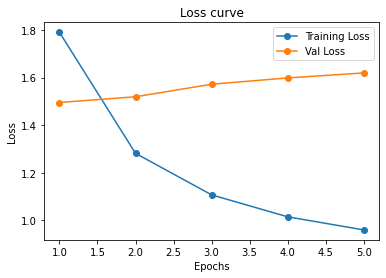

In [ ]:
plt.plot(range(1,6),history_2.history["loss"],label="Training Loss",marker="o")
plt.plot(range(1,6),history_2.history["val_loss"],label="Val Loss",marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss curve")
plt.legend()
plt.show()

In [ ]:
Test_pred_non_lin=model_2.predict([X_test.user_id,X_test.business_id],verbose=1)

19041/19041 [==============================] - 39s 2ms/step


In [ ]:
Test_mse_non_lin=mean_squared_error(y_test,Test_pred_non_lin)
print(f"The MSE of non linear model on test set is {Test_mse_non_lin}")

The MSE of non linear model on test set is 1.6186966199316102


##Model comparison

In [ ]:
lin_train_mse=history_1.history["loss"][-1]
lin_val_mse=history_1.history["val_loss"][-1]
lin_test_mse=test_mse

non_lin_train_mse=history_2.history["loss"][-1]
non_lin_val_mse=history_2.history["val_loss"][-1]
non_lin_test_mse=Test_mse_non_lin


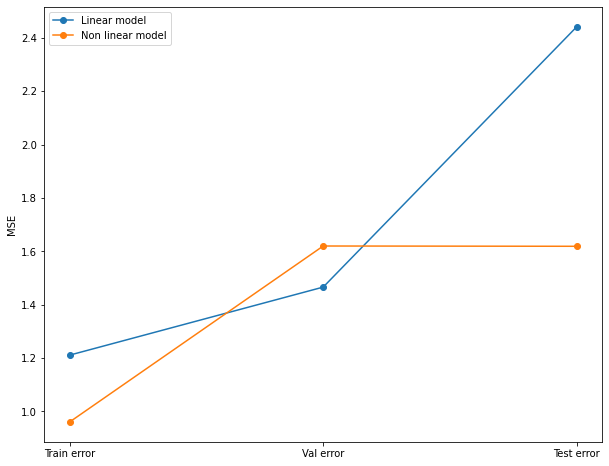

In [ ]:
labels=["Train error","Val error","Test error"]
lin=[lin_train_mse,lin_val_mse,lin_test_mse]
non_lin=[non_lin_train_mse,non_lin_val_mse,non_lin_test_mse]

plt.figure(figsize=(10,8))
ax=plt.gca()

ax.plot([0,1,2],lin,marker="o",label="Linear model")
ax.plot([0,1,2],non_lin,marker="o",label="Non linear model")
ax.set(xlabel='', ylabel='MSE', xticks=[0,1,2], xticklabels=labels)
plt.legend()

From above graph we see that the MSE of linear model on train set and val set is bit lower but on test set is high while on other hand the MSE of nonlinear model on test set is much lower than linear model.

## Model Deployment

In [ ]:
query=make_query("select user_id, business_id from reviews")
review_df=make_dataframe(query,legend=["user_id","business_id"])
review_df.head()


,user_id,business_id
0,92669,1150
1,102147,6047
2,147370,1918
3,2416,1417
4,59423,342


In [ ]:
def similar_rest(user_id):

  """
    Returns list of business id's which could be good prospects for a particular user.
    Factors in location and user's friends' choices

    Parameters:
    user_id : id of user

    returns: list of restaurant ids

  """
  busi_id_list=[]
  #let's find out the restaurants that has been visited by user's friend
  friends_id=user_df[user_df["user_id"]==user_id]["friends"].values[0][1:-1].split(",")
  friends_id.remove("")
  if len(friends_id)!=0:
    for id in friends_id:
      b_ids=review_df[review_df["user_id"]==int(id)]["business_id"].values
      for b_id in b_ids:
        busi_id_list.append(int(b_id))
  else:
    pass
  #we will also consider the restaurant which are at the near by location of the restaurants that has beenvisitedby user.
  user_rated_b_id=review_df[review_df["user_id"]==user_id]["business_id"].values
  if len(user_rated_b_id)!=0:
    for b_id in user_rated_b_id:
      city=business_df[business_df["business_id"]==b_id]["city"].values[0]
      rest_in_city=business_df[business_df["city"]==city]["business_id"].values
      for id in rest_in_city:
        busi_id_list.append(id)

  if busi_id_list==0:
    busi_id_list=list(business_df.business_id.values)
  else:
    pass
  # now in busi_id_list we have the restaurants which has been visited by user's friend and the restaurants which are near by the location of the restaurants
  # which has been visited by user.
  return list(set(busi_id_list))



def recommendation_system(user_id,model=model,top=5):
  """
  Uses Recommendation system to recommend restaurant to user.

    Parameters:
    user_id : id of user
    top : Number of recommendations [5 by default]

    Returns
    data frame of top 5 restaurants with all the details
  """
  restau_ids=similar_rest(user_id)
  user_arr=np.full(shape=(len(restau_ids),1),fill_value=user_id)
  restau_ids_upd = np.array(list(map(lambda x: businid2idx[x],list(restau_ids))))
  user_arr_upd =np.full(shape=(len(restau_ids),1),fill_value=userid2idx[user_id])
  pred=model.predict([user_arr_upd.reshape(-1,1),restau_ids_upd.reshape(-1,1)])
  recomm_df=business_df[business_df.business_id.isin(restau_ids)][["business_id","name","city","stars","categories"]]
  recomm_df["rating"]=pred
  recomm_df.sort_values(by="rating",inplace=True,ascending=False)
  recomm_df.reset_index(drop=True,inplace=True)
  return recomm_df.head(top)






In [ ]:
recommendation_system(user_id=15,top=5)

,business_id,name,city,stars,categories,rating
0,16842,Thai Moon,Arlington,4.0,"Thai, Restaurants, Food, Desserts",3.002947
1,24217,Major Magleashe's,Salem,3.5,"Nightlife, Bars, Dive Bars, Restaurants, Pubs",3.002121
2,16239,King Kong Wings,Atlanta,4.0,"Chicken Wings, Restaurants",3.002096
3,25587,Triangle Coffee,Somerville,4.5,"Coffee & Tea, Cafes, Food, Restaurants",3.002021
4,25908,Flavors of Atlanta Food Tours,Atlanta,5.0,"Food Tours, Local Flavor, Tours, Southern, Res...",3.002015
